In [3]:
import os
import glob

from segmentation import *
from utils.image_io import prepare_image

import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/shaharazulay/anaconda3/envs/dev/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['median', 'average', 'load']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
from _utils import *

In [5]:
path = '../double_dip'

In [6]:
image_name = 'bird.jpg'

In [7]:
im = prepare_image(os.path.join(path + '/images', image_name))

orig_fg = prepare_image(os.path.join(path + '/saliency/output_fg', image_name))
orig_bg = prepare_image(os.path.join(path + '/saliency/output_bg', image_name))


prior_hint_name = image_name.split('.')[0] + '_cluster_hint' + '.jpg' 
prior_fg = prepare_image(os.path.join(path + '/saliency/output_fg', prior_hint_name))
prior_bg = prepare_image(os.path.join(path + '/saliency/output_bg', prior_hint_name))

### Configs 

In [8]:
stage_1_iter = 2000
stage_2_iter = 4000

### Original training 

In [11]:
s = Segmentation(
    "{}_orig".format(image_name.split('.')[0]), 
    im, 
    bg_hint=orig_bg, 
    fg_hint=orig_fg,
    plot_during_training=True,
    show_every=200,
    first_step_iter_num=stage_1_iter,
    second_step_iter_num=stage_2_iter)

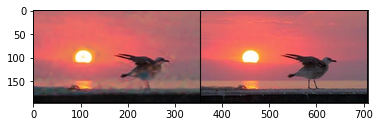

In [12]:
s.optimize()

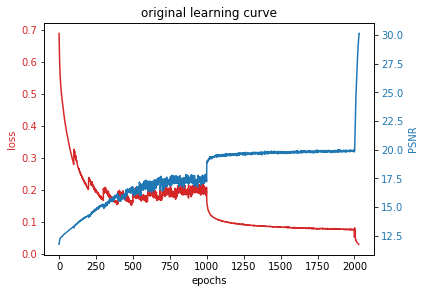

In [13]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss', color=color)
ax1.plot(s.learning_curve, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() 

color = 'tab:blue'
ax2.set_ylabel('PSNR', color=color)
ax2.plot(s.psnr_learning_curve, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 
title('original learning curve');
plt.show()
fig.savefig('output/{}_orig_learning_curve.jpg'.format(image_name.split('.')[0]));

In [14]:
s.finalize()

### Prior-based hint training

In [ ]:
s_prior = Segmentation(
    "{}_cluster".format(image_name.split('.')[0]), 
    im, 
    bg_hint=prior_bg, 
    fg_hint=prior_fg,
    plot_during_training=True,
    show_every=200,
    first_step_iter_num=stage_1_iter,
    second_step_iter_num=stage_2_iter)

In [ ]:
s_prior.optimize()

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss', color=color)
ax1.plot(s_prior.learning_curve, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() 

color = 'tab:blue'
ax2.set_ylabel('PSNR', color=color)
ax2.plot(s_prior.psnr_learning_curve, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 
title('prior-hint learning curve');
plt.show()
fig.savefig('output/{}_prior_learning_curve.jpg'.format(image_name.split('.')[0]));

In [ ]:
s_prior.finalize()

##### Compare learning curves 

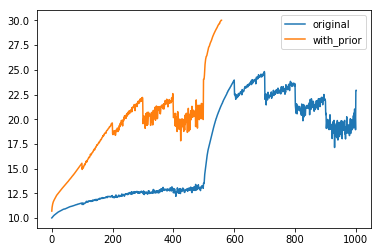

In [194]:
plot(s.psnr_learning_curve);
plot(s_prior.psnr_learning_curve);
legend(['original', 'with_prior'])

### Debug mask 

In [16]:
def _fix_mask(src_image, learned_mask):
    """
    fixing the masks using soft matting
    :return:
    """
    
    new_mask = guidedFilter(
        src_image.transpose(1, 2, 0).astype(np.float32),
        learned_mask[0].astype(np.float32),
        radius=7,
        eps=1e-4)
    
    def to_bin(x):
        v = np.zeros_like(x)
        v[x > 0.5] = 1
        return v

    return to_bin(np.array([new_mask]))

In [ ]:
src_image = s_prior.images[0]
learned_mask_np = torch_to_np(s_prior.mask_net_outputs[0])
fixed_mask_np = s_prior.fixed_masks[0]
test = _fix_mask(src_image, learned_mask_np)

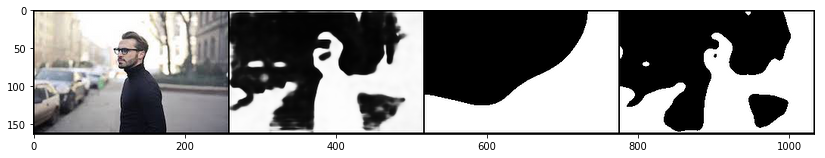

In [197]:
plot_image_grid([src_image, learned_mask_np, fixed_mask_np, test], factor=10);

In [18]:
src_image = s.images[0]
learned_mask_np = torch_to_np(s.mask_net_outputs[0])
fixed_mask_np = s.fixed_masks[0]
test = _fix_mask(src_image, learned_mask_np)

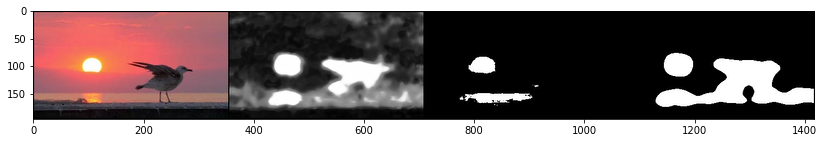

In [19]:
plot_image_grid([src_image, learned_mask_np, fixed_mask_np, test], factor=10);